# Exploratory Data Analysis (EDA)

This is an EDA performed on the real estate market trends in Conneticut. 


The raw data file was obtained from https://catalog.data.gov/dataset/real-estate-sales-2001-2018. On the wbsite, the file is described to include

>town, property address, date of sale, property type (residential, apartment, commercial, industrial or vacant land), sales price, and property assessment. 

>Annual real estate sales are reported by grand list year (October 1 through September 30 each year). For instance, sales from 2018 GL are from 10/01/2018 through 9/30/2019 (Data.gov).



Frequently used libraries are imported:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from bokeh.plotting import figure, show, output_notebook, output_file, reset_output
output_notebook()
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
import osmnx as ox
import geopandas as gpd

Loading BokehJS ...

The dataset imported from the csv file:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from bokeh.plotting import figure, show, output_notebook, output_file, reset_output
output_notebook()
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
import osmnx as ox
import geopandas as gpd
real_estate=pd.read_csv('~/Desktop/BRAINSTATION/data/Real_Estate_Sales_2001-2020_GL.csv')

try:
    real_estate["coordinates"] = ox.geocoder.geocode(real_estate["full_address"])

except ox.geocoder.InsufficientResponseError:
    pass

/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_66403/1003638772.py:1: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  real_estate=pd.read_csv('~/Desktop/BRAINSTATION/data/Real_Estate_Sales_2001-2020_GL.csv')


To get the basic idea about the dataset, 10 rows are called:

Findings:

- Serial number does not match the index
- Specific `Address`es and `Town`s are avilable
- `Sales ratio` is `Assessed Value` / `Sale Amount`
- NaN values for several columns
- `Date Recorded` is date of sale according to the website.
- Some rows in `Location` include longitude and latitude.

Next, file types are checked:

In [14]:
real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997213 entries, 0 to 997212
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Serial Number     997213 non-null  int64  
 1   List Year         997213 non-null  int64  
 2   Date Recorded     997211 non-null  object 
 3   Town              997213 non-null  object 
 4   Address           997162 non-null  object 
 5   Assessed Value    997213 non-null  float64
 6   Sale Amount       997213 non-null  float64
 7   Sales Ratio       997213 non-null  float64
 8   Property Type     614767 non-null  object 
 9   Residential Type  608904 non-null  object 
 10  Non Use Code      289681 non-null  object 
 11  Assessor Remarks  149864 non-null  object 
 12  OPM remarks       9934 non-null    object 
 13  Location          197697 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 106.5+ MB


In [15]:
#Missing values check
real_estate.isna().sum()

Serial Number            0
List Year                0
Date Recorded            2
Town                     0
Address                 51
Assessed Value           0
Sale Amount              0
Sales Ratio              0
Property Type       382446
Residential Type    388309
Non Use Code        707532
Assessor Remarks    847349
OPM remarks         987279
Location            799516
dtype: int64

Findings:
   - `Date` column can be changed to DateTime format
   - `Date Recorded`, `Town`, `Address`, `Assessed Value`, `Sale Amount`, `Sale Ratio` have very few missing values.
   - Address has 51 missingcolumns.
   - About 1/3 of rows missing in `Property Type` and `Residential Type`.
   - About 20% of the data has `Location` or longitude and latitude.
   

In [16]:
#Change data type
real_estate['Date Recorded'] = pd.to_datetime(real_estate['Date Recorded'])

In [108]:
real_estate.describe()

,Serial Number,List Year,Assessed Value,Sale Amount,Sales Ratio
count,9.972130e+05,997213.000000,9.972130e+05,9.972130e+05,9.972130e+05
mean,4.311864e+05,2010.189829,2.791437e+05,3.911512e+05,1.044637e+01
std,6.549219e+06,6.237877,1.670610e+06,5.347270e+06,1.890192e+03
min,0.000000e+00,2001.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.044400e+04,2004.000000,8.760000e+04,1.400000e+05,4.867000e-01
50%,7.030300e+04,2010.000000,1.383900e+05,2.250000e+05,6.246000e-01
75%,1.518780e+05,2016.000000,2.255600e+05,3.650000e+05,7.852761e-01
max,2.000500e+09,2020.000000,8.815100e+08,5.000000e+09,1.226420e+06


In [109]:
for column in (real_estate.columns):
    nunique_values = real_estate[column].nunique()
    unique_values = real_estate[column].unique()
    value_counts = real_estate[column].value_counts()
    
    print(f"The column name is {column}\n")
    print(f"The total number of unique values are: {nunique_values}\n")
    print(f"The unique values are: {unique_values}\n\n\n\n")
    print(f"The value counts are: {value_counts}\n\n\n\n")

The column name is Serial Number

The total number of unique values are: 83537

The unique values are: [2020348   20002  200212 ... 1900749 1900695 1910419]




The value counts are: 10010      172
10018      172
10002      172
10003      171
10009      171
          ... 
124743       1
124571       1
125068       1
124724       1
1910419      1
Name: Serial Number, Length: 83537, dtype: int64




The column name is List Year

The total number of unique values are: 20

The unique values are: [2020 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019]




The value counts are: 2004    84056
2020    66592
2003    64239
2005    61602
2002    59682
2001    59584
2019    58954
2018    50709
2016    49773
2014    49563
2006    48785
2015    46651
2017    45691
2009    42508
2013    39943
2012    35973
2007    35617
2010    33491
2008    32735
2011    31065
Name: List Year, dtype: int64




The column name is Date Recorded

The total number of unique

The column name is OPM remarks

The total number of unique values are: 4825

The unique values are: [nan 'GAS STATION' 'GOOD SALE PER MLS' ... 'INCLUDES #19158'
 'TOTAL RENOVATION PER MLS - SEE PREVIOUS SALE #1900075'
 'PER MLS CLOSING PRICE = $1,145,000']




The value counts are: GOOD SALE PER MLS                                                   978
NO MLS                                                              500
NEW CONSTRUCTION                                                    345
SHORT SALE PER MLS                                                  326
TOTAL RENOVATION PER MLS                                            316
                                                                   ... 
REMODELED PER MLS - SEE PREVIOUS SALE #170076                         1
REO SALE - CASH ONLY SOLD AS IS                                       1
TWO SALES - ALSO SEE #1700209                                         1
NOT A VALID SALE PER TOWN SITE AND PER MLS SALE PRICE = $345,000     

In [ ]:
real_estate[]

`Serial Number` is not synonymous with the index. There are 83537 unique serial numbers for 1M rows, and some of the serial numbers

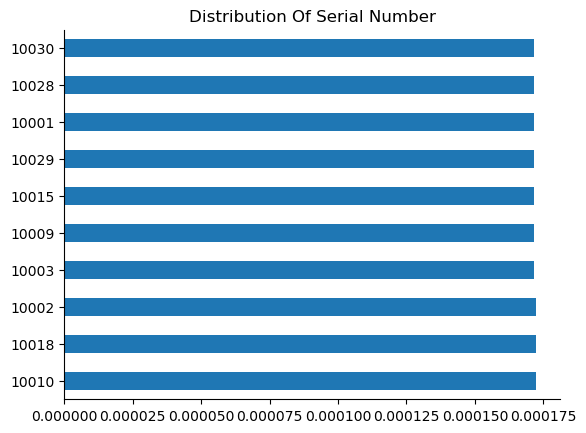

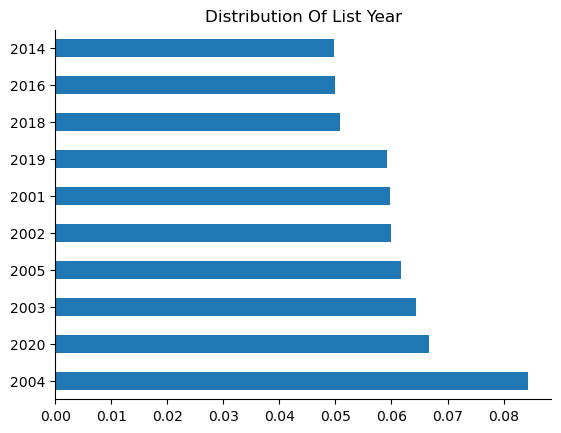

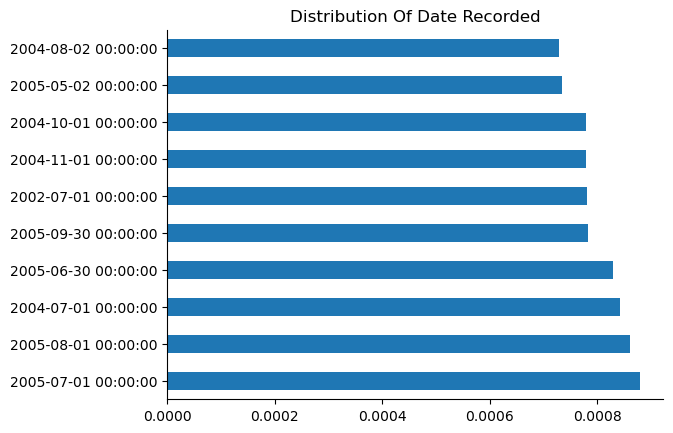

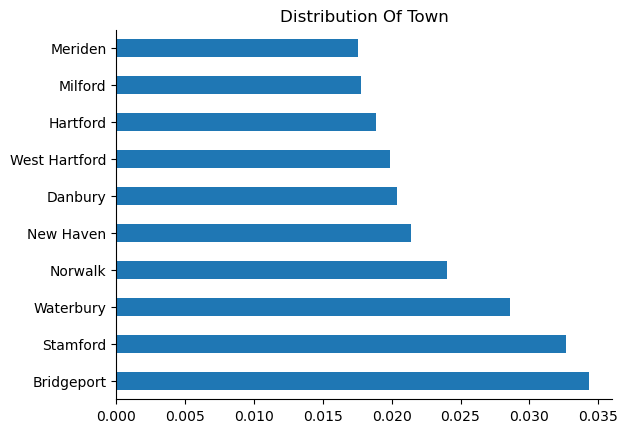

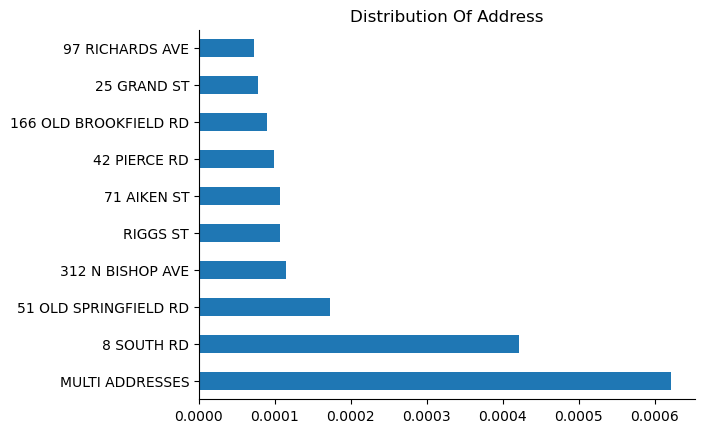

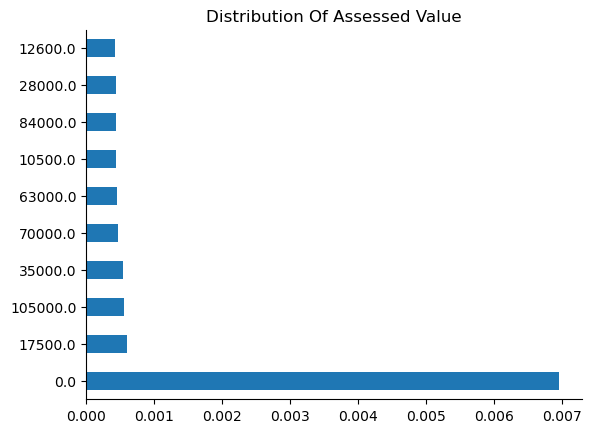

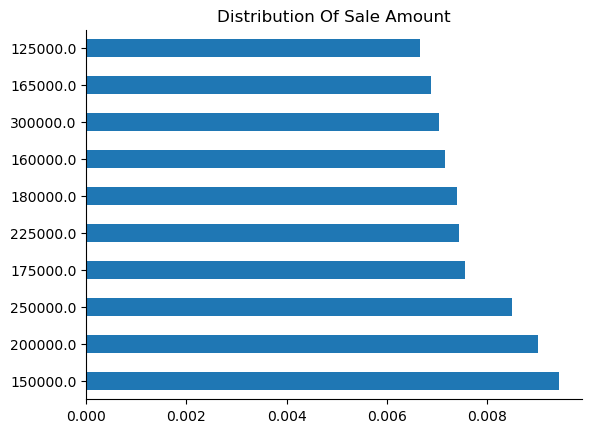

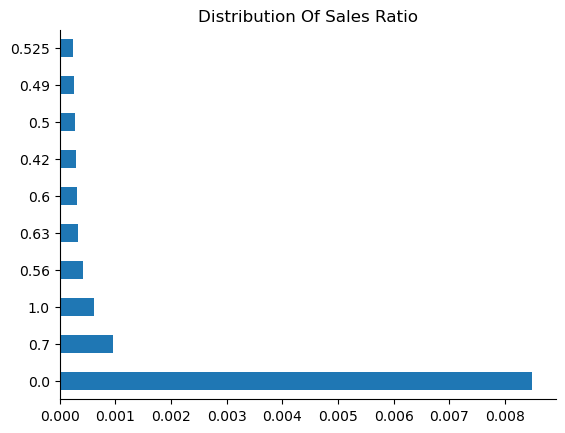

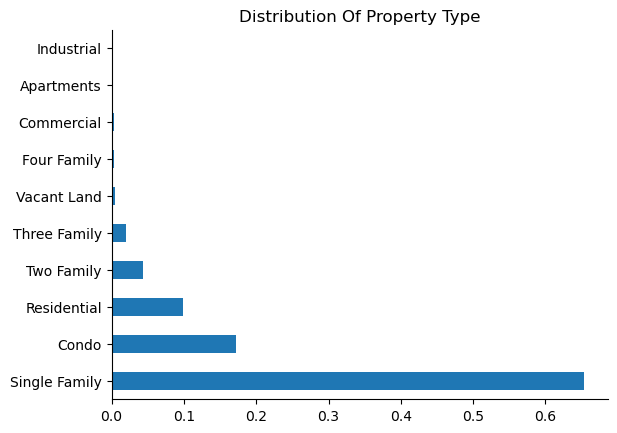

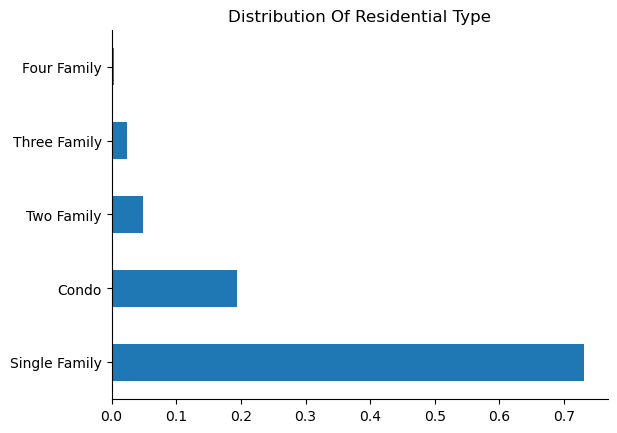

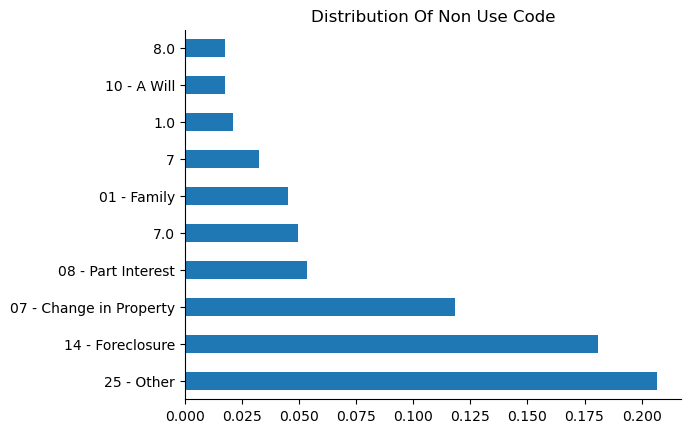

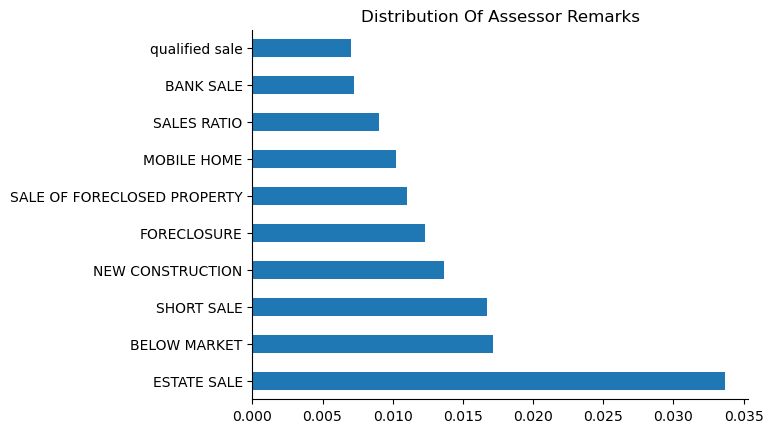

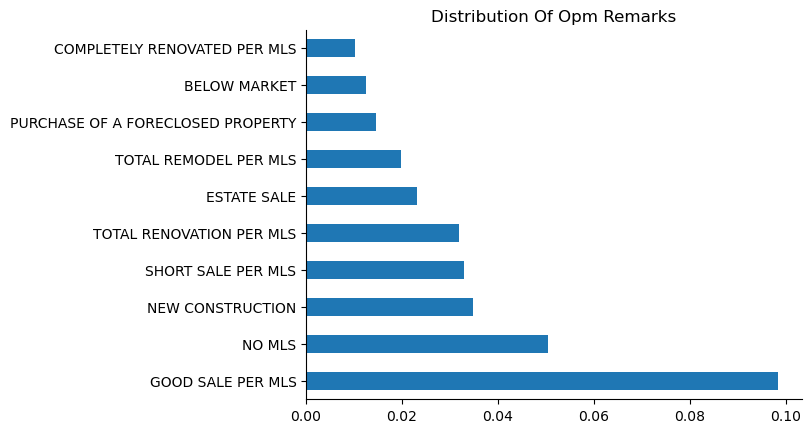

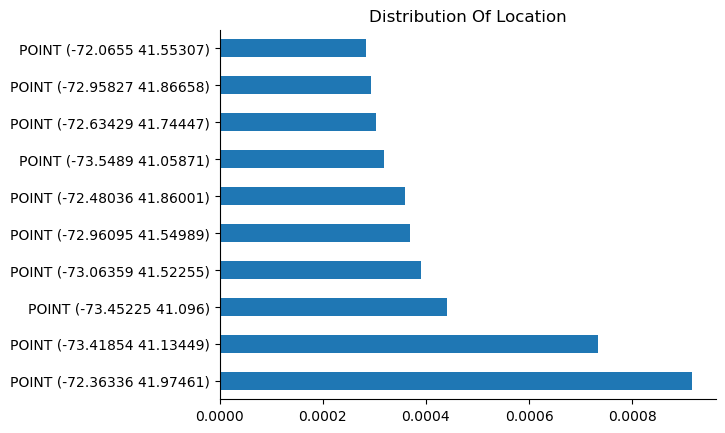

In [110]:
for column in real_estate:
    
    # limit to top 10 counts - too many locations to plot
    real_estate[column].value_counts(normalize=True).head(10).plot(kind="barh")

    plt.title(f"Distribution of {column}".title())
    sns.despine()
    plt.show()

/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_28475/1560488043.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = real_estate.corr()


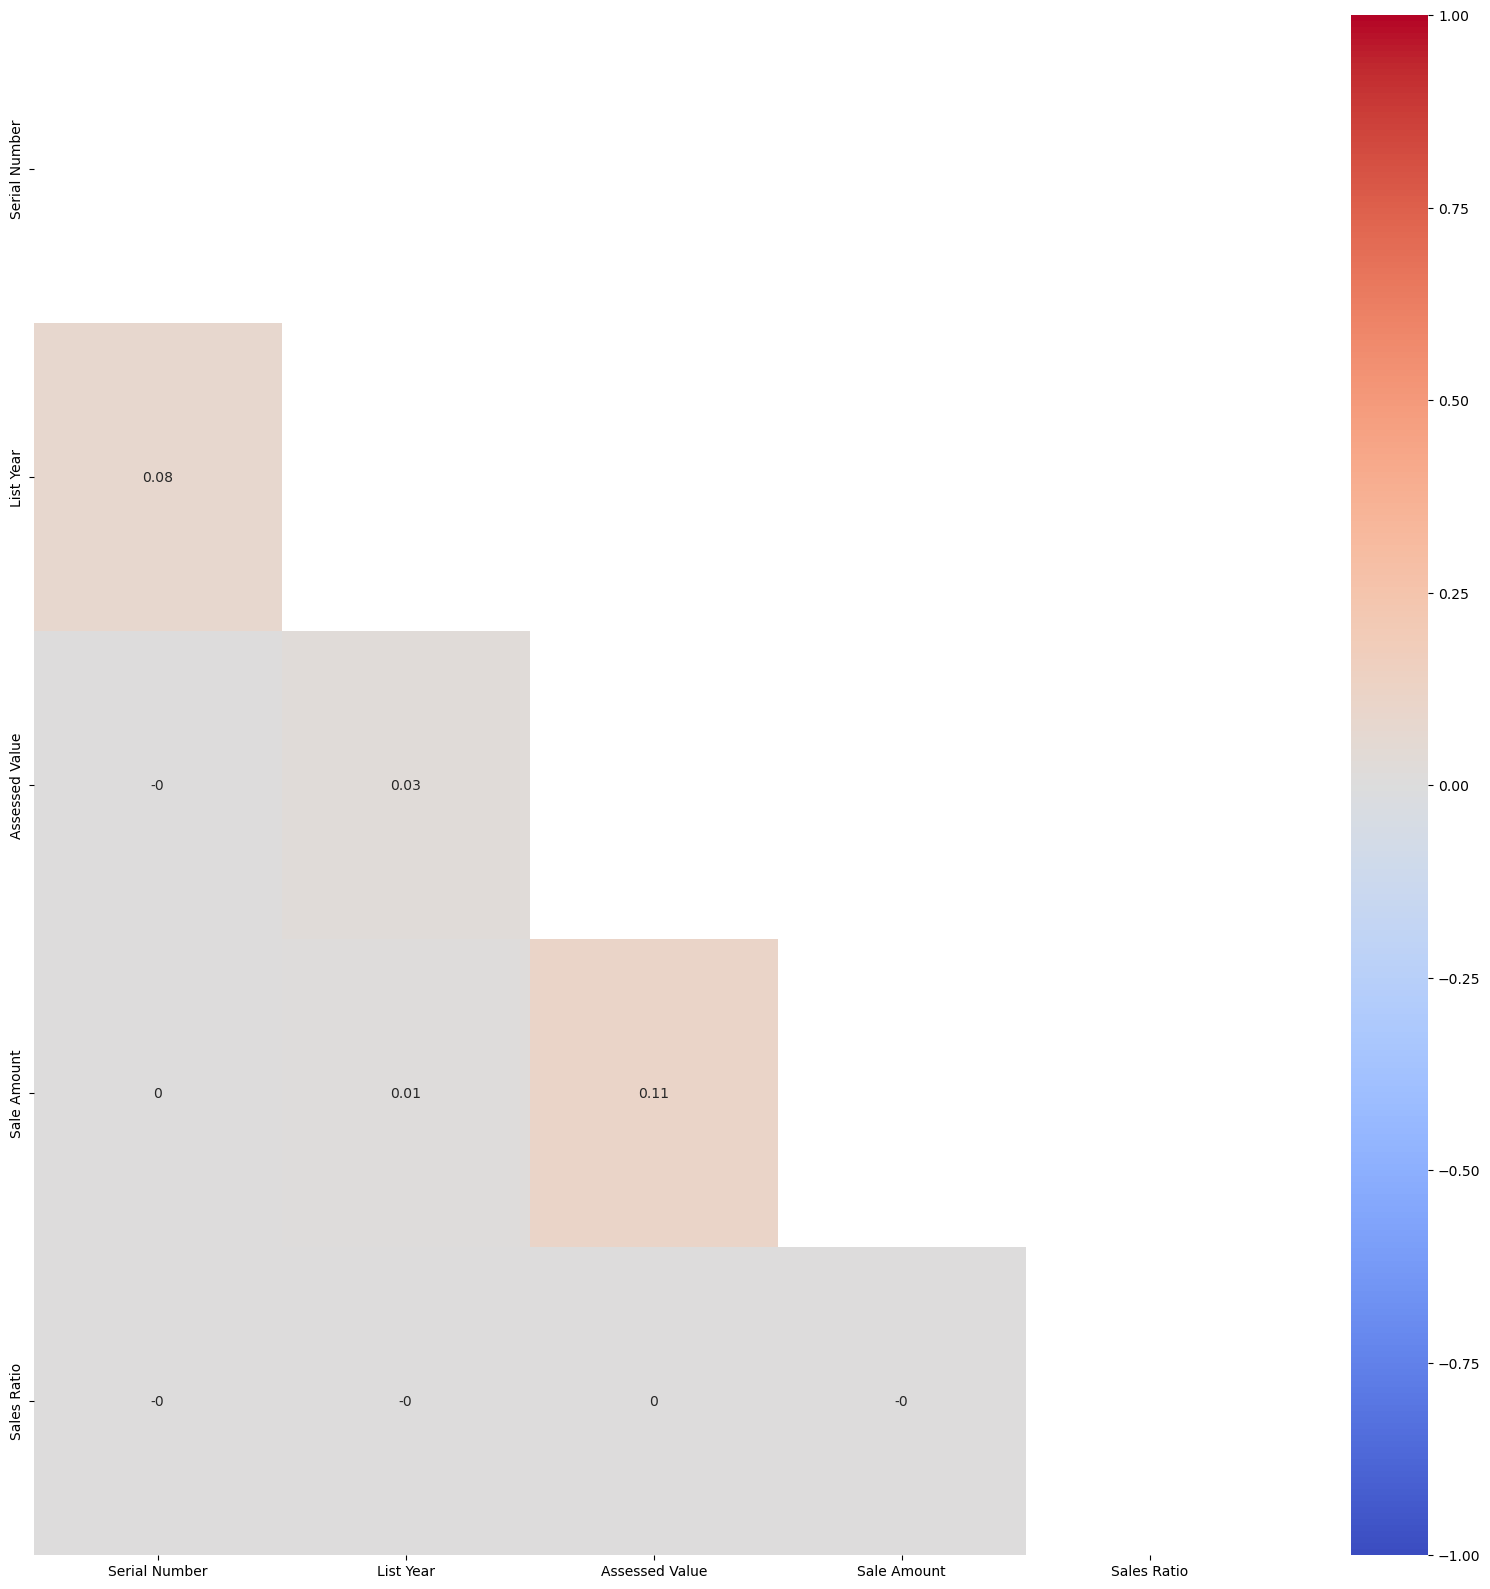

In [111]:
corr_df = real_estate.corr()
mask = np.triu(corr_df)
plt.figure(figsize=(20,20))
sns.heatmap(corr_df.round(2), annot=True,mask=mask, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

Findings:
   - `Assessed Value` and `Sale Amount` is weakly correlated (r=0.11).

In [112]:
real_estate.groupby(['Property Type', 'Residential Type'])['Property Type'].count() 

Property Type  Residential Type
Condo          Condo               105420
Four Family    Four Family           2150
Residential    Condo                12360
               Four Family            268
               Single Family        43404
               Three Family          1495
               Two Family            3201
Single Family  Single Family       401612
Three Family   Three Family         12586
Two Family     Two Family           26408
Name: Property Type, dtype: int64

<Axes: xlabel='List Year', ylabel='Sale Amount'>

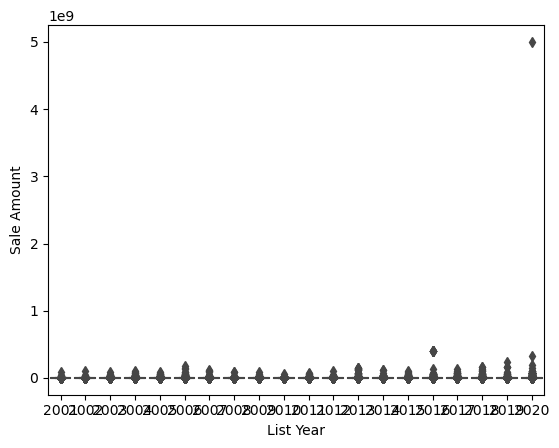

In [25]:
sns.boxplot(x='List Year', y='Sale Amount', data=real_estate)

In [113]:
# Assuming 'real_estate' is a pandas DataFrame with a 'Sale Amount' column
print(real_estate[real_estate['Sale Amount'] == real_estate['Sale Amount'].max()])

       Serial Number  List Year Date Recorded        Town           Address  \
59835       20200091       2020    2021-08-19  Willington  456 TOLLAND TPKE   

       Assessed Value   Sale Amount  Sales Ratio Property Type  \
59835       2238530.0  5.000000e+09     0.000448    Apartments   

      Residential Type Non Use Code       Assessor Remarks  \
59835              NaN   25 - Other  APARTMENTS-COMMERICAL   

                OPM remarks Location  
59835  INCORRECT SALE PRICE      NaN  


In the `OPM remarks`, it is stated that an *INCORRECT SALE PRICE* is inserted. So this row will be deleted and will investigate if other rows have the same comment.

In [11]:
real_estate[real_estate['OPM remarks']== 'INCORRECT SALE PRICE']

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
59835,20200091,2020,08/19/2021,Willington,456 TOLLAND TPKE,2238530.0,5.000000e+09,0.000448,Apartments,NaN,25 - Other,APARTMENTS-COMMERICAL,INCORRECT SALE PRICE,NaN
65620,20200102,2020,09/28/2021,Willington,7 TOLLAND TURNPIKE ROAD,112040.0,1.941491e+08,0.000577,Residential,Three Family,25 - Other,MULTI FAMILY,INCORRECT SALE PRICE,NaN


/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_28475/1412154279.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.barh(real_estate.groupby('Property Type').mean()["Sale Amount"].index, real_estate.groupby('Property Type').mean()["Sale Amount"])
/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_28475/1412154279.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.barh(real_estate.groupby('Property Type').mean()["Sale Amount"].index, real_estate.groupby('Property Type').mean()["Sale Amount"])


Text(0.5, 1.0, 'Mean Sale Amount by Property Type')

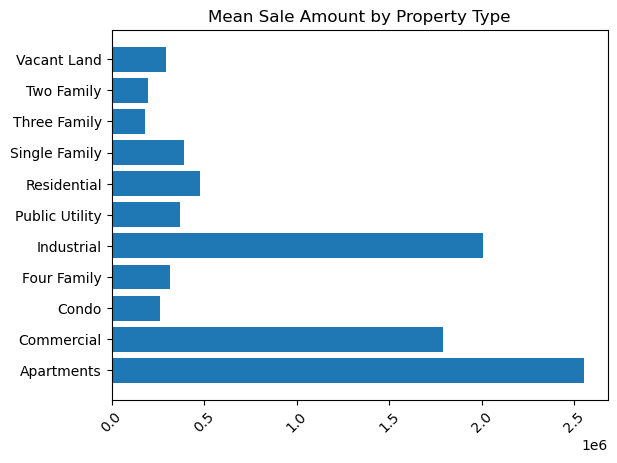

In [119]:
plt.barh(real_estate.groupby('Property Type').mean()["Sale Amount"].index, real_estate.groupby('Property Type').mean()["Sale Amount"])
plt.xticks(rotation=45)
plt.title('Mean Sale Amount by Property Type')


/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_28475/3408167422.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.barh(real_estate.groupby('List Year').mean()['Sale Amount'].index, real_estate.groupby('List Year').mean()["Sale Amount"])
/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_28475/3408167422.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.barh(real_estate.groupby('List Year').mean()['Sale Amount'].index, real_estate.groupby('List Year').mean()["Sale Amount"])


Text(0.5, 1.0, 'Mean Sale Amount by List Year')

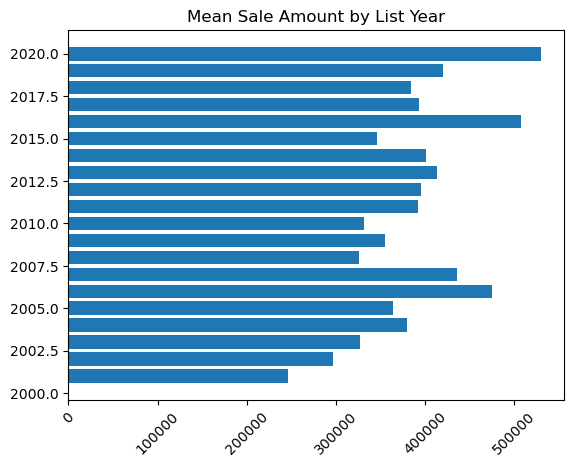

In [120]:
plt.barh(real_estate.groupby('List Year').mean()['Sale Amount'].index, real_estate.groupby('List Year').mean()["Sale Amount"])
plt.xticks(rotation=45)
plt.title('Mean Sale Amount by List Year')
